In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Bidirectional

import json
import urllib
import numpy as np

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url,'sarcasm.json')

with open('sarcasm.json') as f:
    datas = json.load(f)

- sarcasm.json
> * article_link: 기사의 link
> * headline: 기사의 제목 (X)
> * is_sarcastic: 비꼬는 기사인지의 여부 (y)

In [3]:
sentences = [] # headline
labels = []    # is_sarcastic

for data in datas:
  sentences.append(data['headline'])
  labels.append(data['is_sarcastic'])

In [4]:
print(sentences[:2]) # X
print(labels[:2])    # y

["former versace store clerk sues over secret 'black code' for minority shoppers", "the 'roseanne' revival catches up to our thorny political mood, for better and worse"]
[0, 0]


In [5]:
# 20000개의 문장은 training data로, 나머지 문장은 test data로 사용함
train_sentences = sentences[:20000]
train_labels = labels[:20000]

test_sentences = sentences[20000:]
test_labels = labels[20000:]
# training과 test를 위한 text와 label

- text를 수로 변경하는 과정이 필요

# Tokenizer

In [6]:
tok = Tokenizer(num_words=5000,oov_token='<OOV>')
# Tokenizer(num_words, oov_token)
# num_words: 사전에 포함된 단어의 수
# oov_token: 단어 사전에 포함되지 않는 단어를 대체할 문자열

In [7]:
# Tokenizer에 text를 입력하여 사전을 생성: 단어에 숫자를 배정
tok.fit_on_texts(train_sentences)

In [8]:
tok.word_index
# 단어의 숫자가 할당되는 규칙의 등장하는 빈도수이다. (많이 등장할 수 록 작은 값을 갖는다.)

{'<OOV>': 1,
 'to': 2,
 'of': 3,
 'the': 4,
 'in': 5,
 'for': 6,
 'a': 7,
 'on': 8,
 'and': 9,
 'with': 10,
 'is': 11,
 'new': 12,
 'trump': 13,
 'man': 14,
 'from': 15,
 'at': 16,
 'about': 17,
 'you': 18,
 'by': 19,
 'this': 20,
 'after': 21,
 'be': 22,
 'up': 23,
 'out': 24,
 'that': 25,
 'how': 26,
 'as': 27,
 'it': 28,
 'not': 29,
 'are': 30,
 'your': 31,
 'what': 32,
 'his': 33,
 'all': 34,
 'he': 35,
 'will': 36,
 'who': 37,
 'just': 38,
 'has': 39,
 'more': 40,
 'one': 41,
 'year': 42,
 'into': 43,
 'report': 44,
 'have': 45,
 'why': 46,
 'over': 47,
 'area': 48,
 'u': 49,
 'donald': 50,
 'says': 51,
 'day': 52,
 'can': 53,
 's': 54,
 'first': 55,
 'woman': 56,
 'time': 57,
 'like': 58,
 'get': 59,
 'old': 60,
 'no': 61,
 'her': 62,
 "trump's": 63,
 'off': 64,
 'now': 65,
 'an': 66,
 'obama': 67,
 'life': 68,
 'people': 69,
 'women': 70,
 'house': 71,
 "'": 72,
 'was': 73,
 'still': 74,
 'white': 75,
 'back': 76,
 'make': 77,
 'than': 78,
 'clinton': 79,
 'down': 80,
 'when': 8

In [9]:
# text인 sentence를 숫자 sequence로 변경
train_seq = tok.texts_to_sequences(train_sentences)
test_seq = tok.texts_to_sequences(test_sentences)

In [10]:
print(train_sentences[100])
print(train_seq[100])

demi lovato drops emotional 'nightingale' music vid
[4843, 4844, 1880, 859, 1, 402, 1]


In [11]:
# 문장 길이 통일
train_pad = pad_sequences(train_seq,maxlen=15,truncating='post',padding='post')
# pad_sequences(sequences,maxlen,truncating,padding)
# - sequences: text에서 number로 변경한 sequences
# - maxlen: 문장의 길이 (모든 문장의 길이를 동일하게 조정해야 함)
# - truncating: 지정된 길이보다 긴 문장을 잘라낼 위치 (post:뒤, pre:앞)
# - padding: 지정된 길이보다 짧은 문장에 0을 채울 위치 (post:뒤, pre:앞)
test_pad = pad_sequences(test_seq,maxlen=15,truncating='post',padding='post')

# pad_sequences의 결과는 ndarray이다.
# train_sentences와 train_seq은 list type이다.

In [12]:
# labels(y)도 ndarray로 변경함
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# model

In [13]:
model = Sequential([
    Embedding(5000,16,input_length=15),
    # Embedding(사전에 포함된 단어의 수, 줄이고자하는 차원, input_length=문장의 길이)
    Bidirectional(LSTM(64,return_sequences=True)),
    # LSTM(node의 수, return_sequences)
    # 다음 layer가 LSTM으로 연결된 경우, return_sequence를 True로 설정한다. default로 False가 설정되어 있음
    Bidirectional(LSTM(32)),

    Dense(32,activation='relu'),
    # 0 또는 1, 2개의 class로 분류하므로 output layer의 node는 2개로 지정함
    Dense(2,activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 16)            80000     
                                                                 
 lstm (LSTM)                 (None, 15, 64)            20736     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 114274 (446.38 KB)
Trainable params: 114274 (446.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])

In [16]:
result = model.fit(train_pad,train_labels,epochs=20,batch_size=256,validation_split=0.3)

Epoch 1/20
55/55 [==============================] - 15s 90ms/step - loss: 0.6055 - acc: 0.6404 - val_loss: 0.3912 - val_acc: 0.8227
Epoch 2/20
55/55 [==============================] - 4s 65ms/step - loss: 0.3166 - acc: 0.8684 - val_loss: 0.3560 - val_acc: 0.8428
Epoch 3/20
55/55 [==============================] - 3s 58ms/step - loss: 0.2329 - acc: 0.9062 - val_loss: 0.3806 - val_acc: 0.8423
Epoch 4/20
55/55 [==============================] - 5s 97ms/step - loss: 0.1940 - acc: 0.9282 - val_loss: 0.4119 - val_acc: 0.8357
Epoch 5/20
55/55 [==============================] - 3s 63ms/step - loss: 0.1707 - acc: 0.9373 - val_loss: 0.4476 - val_acc: 0.8377
Epoch 6/20
55/55 [==============================] - 3s 62ms/step - loss: 0.1578 - acc: 0.9434 - val_loss: 0.4891 - val_acc: 0.8303
Epoch 7/20
55/55 [==============================] - 4s 81ms/step - loss: 0.1417 - acc: 0.9509 - val_loss: 0.4920 - val_acc: 0.8290
Epoch 8/20
55/55 [==============================] - 4s 78ms/step - loss: 0.1277 - 

In [17]:
model.evaluate(test_pad,test_labels)

210/210 [==============================] - 1s 6ms/step - loss: 0.7790 - acc: 0.8062


[0.7789973020553589, 0.8062304258346558]

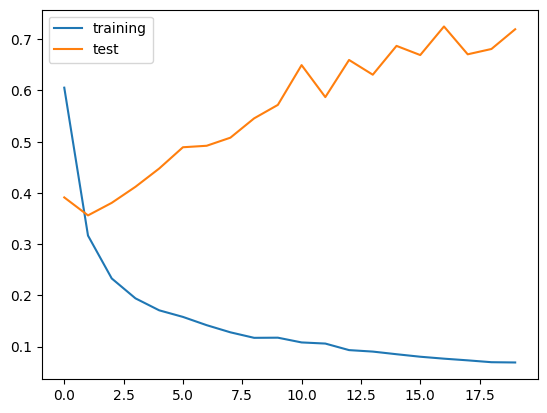

In [18]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'],label='training')
plt.plot(result.history['val_loss'],label='test')
plt.legend()

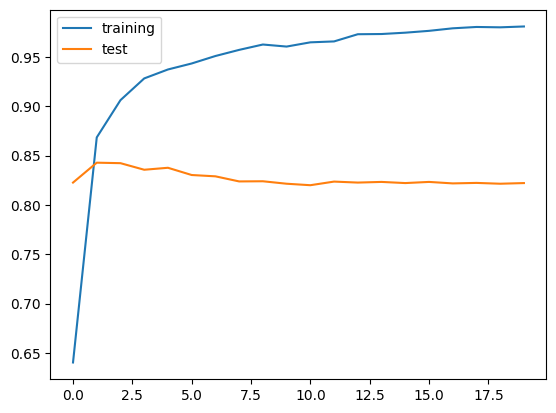

In [19]:
import matplotlib.pyplot as plt

plt.plot(result.history['acc'],label='training')
plt.plot(result.history['val_acc'],label='test')
plt.legend()